# Module 5: Graph RAG

*Part of the RCD Workshops series: Retrieval-Augmented Generation (RAG) for Advanced Research Applications*

---

So far, retrieval found text snippets. What if your knowledge isn't just documents—but a **knowledge graph**?


## What is Graph RAG?
A **knowledge graph (KG)** organizes data as entities (nodes) and relationships (edges): facts like (Subject —relation→ Object).
Graphs let you represent links across topics and discover answers even when no single document states them directly.

> **Diagram placeholder:** Network visualization of a small knowledge graph: researchers, papers, citations.

### 5.1 Why Knowledge Graphs?
- **Multi-hop answers**: Answer questions that require tracing connections (e.g., "Which startups were founded by former Google employees?").
- **Structured queries (SPARQL, Cypher)**: Let LLMs generate graph queries from user input.
- **Context beyond text**: Some info is implicit and scattered across documents, but explicit in the graph.

### 5.2 Approaches
1. **Vector-based retrieval over nodes/edges:** Treat node/edge texts as documents; embed and run semantic search (baseline RAG, but on graph content).
2. **Prompt-to-Graph Query:** Use the LLM to translate the user’s question to a graph query (e.g. SPARQL/Cypher), then fetch subgraph to answer.
3. **Hybrid:** Use vectors to find graph entities, then expand by graph traversal.

### 5.3 Hands-on Demo: Building/Querying a Knowledge Graph
Let’s use NetworkX to create and query a tiny toy KG.

### Dataset: Demo Corpus

We will use a tiny mixed-domain corpus (AI, Climate, Biomedical, Materials) stored in `data/demo_corpus.jsonl`.


In [11]:
from pathlib import Path
import pandas as pd

DATA_PATH = 'data/demo_corpus.jsonl'
df = pd.read_json(DATA_PATH, lines=True)
docs = df.to_dict('records')
print(f'Loaded {len(docs)} docs from {DATA_PATH}')
display(df[['id','title','year','authors','topics']].head())


Loaded 18 docs from data/demo_corpus.jsonl


,id,title,year,authors,topics
0,2508.05366,Can Language Models Critique Themselves? Inves...,2025,"[Samy Ateia, Udo Kruschwitz]","[NLP, Retrieval, Language Model, Biomedical]"
1,2508.07326,Nonparametric Reaction Coordinate Optimization...,2025,"[Polina V. Banushkina, Sergei V. Krivov]","[ML, Climate]"
2,2508.07654,MLego: Interactive and Scalable Topic Explorat...,2025,"[Fei Ye, Jiapan Liu, Yinan Jing, Zhenying He, ...","[Databases, IR]"
3,2508.07798,Generative Inversion for Property-Targeted Mat...,2025,"[Cheng Li, Pengfei Danga, Yuehui Xiana, Yumei ...","[Materials, ML]"
4,2508.08140,Data-Efficient Biomedical In-Context Learning:...,2025,"[Jun Wang, Zaifu Zhan, Qixin Zhang, Mingquan L...","[NLP, Retrieval, Language Model, Biomedical]"


In [12]:
import networkx as nx
# Build a heterogeneous graph from the demo corpus: Authors, Papers, Topics
G = nx.DiGraph()

# Limit to a small subset for readable visualization (adjust as needed)
MAX_PAPERS = 15
records = df.head(MAX_PAPERS).to_dict('records')

for rec in records:
    pid = rec.get('id')
    title = rec.get('title', '')
    year = rec.get('year')
    topics = rec.get('topics', []) or []
    authors = rec.get('authors', []) or []
    # Paper node
    G.add_node(pid, type='Paper', title=title, year=year)
    # Author -> Paper edges
    for author in authors:
        G.add_node(author, type='Author')
        G.add_edge(author, pid, relation='authored')
    # Paper -> Topic edges
    for topic in topics:
        G.add_node(topic, type='Topic')
        G.add_edge(pid, topic, relation='has_topic')

print(f'Graph built: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges')
print('Node types:', {t for t in set(nx.get_node_attributes(G, 'type').values())})


Graph built: 96 nodes, 117 edges
Node types: {'Author', 'Paper', 'Topic'}


### 5.3.1 Visualizing the Graph
A quick view of the nodes (Researchers vs Papers) and edge relations.

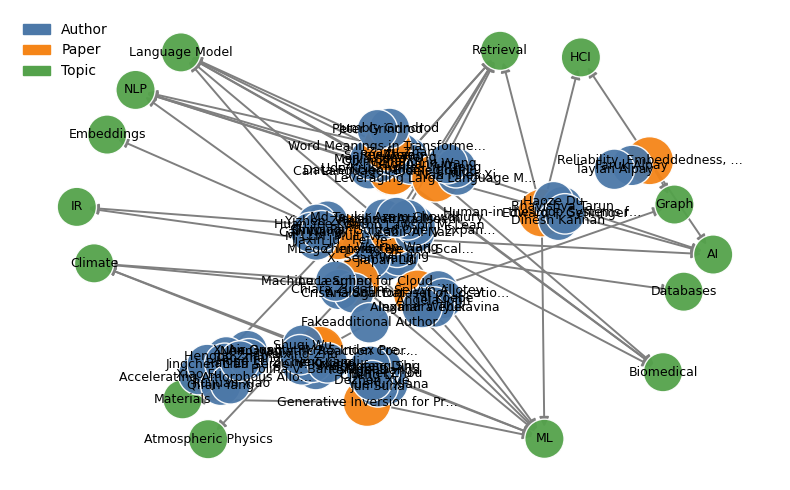

In [13]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
# Layout and node styling
pos = nx.spring_layout(G, seed=42)
node_types = nx.get_node_attributes(G, 'type')
# Color map for node types
type_color = {'Author': '#4C78A8', 'Paper': '#F58518', 'Topic': '#54A24B'}
colors = [type_color.get(node_types.get(n), '#7F7F7F') for n in G.nodes()]
sizes = [850 if node_types.get(n) == 'Author' else (1200 if node_types.get(n) == 'Paper' else 800) for n in G.nodes()]
plt.figure(figsize=(8, 5))
nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=sizes, alpha=0.95, linewidths=1, edgecolors='white')
# Labels: show shortened paper titles; authors/topics as-is
def short(s, n=28):
    s = str(s)
    return s if len(s) <= n else s[: n - 1] + '…'
labels = {}
for n in G.nodes():
    t = node_types.get(n)
    if t == 'Paper':
        labels[n] = short(G.nodes[n].get('title', n))
    else:
        labels[n] = n
nx.draw_networkx_labels(G, pos, labels=labels, font_size=9)
nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle='-|>', arrowsize=14, width=1.4, edge_color='#7F7F7F')
# Optionally draw edge labels if small enough to read
if G.number_of_edges() <= 30:
    edge_labels = nx.get_edge_attributes(G, 'relation')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, label_pos=0.45)
# Legend
legend_handles = [
    Patch(color=type_color['Author'], label='Author'),
    Patch(color=type_color['Paper'], label='Paper'),
    Patch(color=type_color['Topic'], label='Topic'),
]
plt.legend(handles=legend_handles, frameon=False, loc='upper left')
plt.axis('off')
plt.tight_layout()
plt.show()


- **Example query:** "Which authors wrote papers about a given topic?"
Let's traverse the graph to answer (Author → Paper → Topic).

In [14]:
# Pick a target topic that's present in the subset
all_topics = sorted({t for rec in records for t in (rec.get('topics') or [])})
TARGET_TOPIC = 'Climate' if 'Climate' in all_topics else (all_topics[0] if all_topics else None)
print('Available topics:', all_topics)
print('Target topic:', TARGET_TOPIC)

authors_for_topic = set()
if TARGET_TOPIC is not None:
    # Walk Author -> Paper -> Topic
    for author, paper, ed in G.edges(data=True):
        if ed.get('relation') == 'authored':
            # Check if this paper links to the target topic
            for _, topic, td in G.out_edges(paper, data=True):
                if td.get('relation') == 'has_topic' and topic == TARGET_TOPIC:
                    authors_for_topic.add(author)

print(f'Authors with papers on "{TARGET_TOPIC}":', sorted(authors_for_topic))


Available topics: ['AI', 'Atmospheric Physics', 'Biomedical', 'Climate', 'Databases', 'Embeddings', 'Graph', 'HCI', 'IR', 'Language Model', 'ML', 'Materials', 'NLP', 'Retrieval']
Target topic: Climate
Authors with papers on "Climate": ['Alexandra Tyukavina', 'Angela John', 'Chiara Zugarini', 'Cristina Sgattoni', 'Fakeadditional Author', 'He Guandi', 'Ingmar Weber', 'Luca Sgheri', 'Meixing Zhu', 'Polina V. Banushkina', 'Selvyn Allotey', 'Sergei V. Krivov', 'Shuqi Wu', 'Till Koebe', 'Zicheng Guo']


### 5.4 Integrating Graphs with an LLM
- **Linearize the subgraph:** Convert facts to sentences and give as context (e.g. "Bob authored Paper2. Paper2 cites Paper1. Alice authored Paper1.").
- **Embed graph context as text:** Each triple can be a sentence embedded with the query.
- **LLM as a reasoner:** Some advanced agents let the LLM interactively traverse a graph (multi-hop reasoning loop)—beyond scope for now.

#### Applications
- Science: concept/citation networks for tracing idea influence.
- Medicine: biomedical KGs link genes, proteins, drugs, diseases.
- Enterprise: org charts, policy graphs, etc.


### Reflection
In what kinds of research would a graph-based RAG be most beneficial compared to text-only retrieval?

In [ ]:
from utils import create_answer_box
create_answer_box('📝 **Your Answer:** Graph RAG would be most useful for ...', question_id='mod5_graph_rag_application')